In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

## Применение SVD к матрице значений функции на 2-мерной сетке

Для гладких функций сингулярные числа такой матрицы всегда будут быстро "затухать"

Text(0.5, 0, 'y')

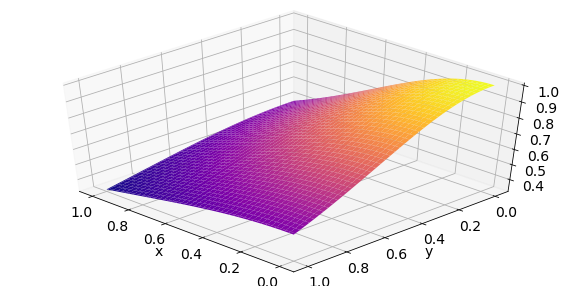

In [3]:
import numpy as np
n = 128
t = np.linspace(0, 1, n)
x, y = np.meshgrid(t, t)
f = 1/(x**2 + y**2 + 1) 
# f = np.sin(10*x/(y+1)**2)**2 * np.cos(1*(x-0.5)+ 8*y)**3
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(45, 135)
ax.plot_surface(x, y, f, cmap = 'plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')

Построим график зависимости сингулярных чисел от номера в логарифмической шкале

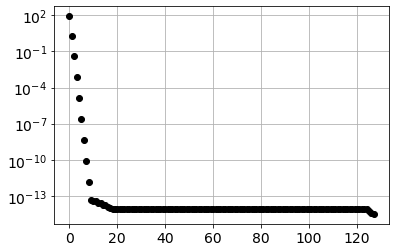

In [4]:
u, s, v = np.linalg.svd(f)
plt.semilogy(s,'ko')
plt.grid(True)

Оставим несколько первых сингулярных чисел, возьмём обрезанное разложение, и посчитаем ошибку

error = 9.02e-14


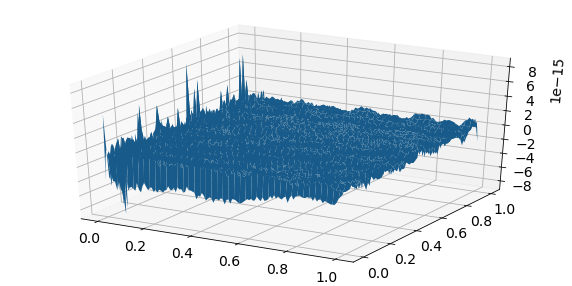

In [5]:
r = 10
ur = u[:, :r]
sr = s[:r]
vr = v[:r, :] # Транспонированная матрица
fappr = ur @ np.diag(sr) @ vr
er = np.linalg.norm(fappr - f, 'fro')
print('error = {0:5.2e}'.format(er))
fig = plt.figure(figsize = (10,5))
ax2 = fig.add_subplot(1, 1, 1, projection='3d')
ax2.plot_surface(x, y, fappr - f)

## Сжатие изображений

Применим SVD отдельно для матрицы значений каждого канала (RGB)

(333, 500, 3) uint8


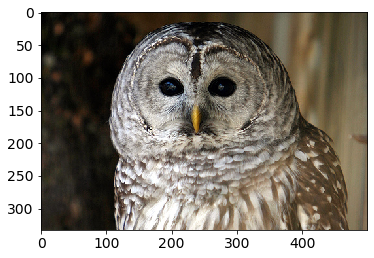

In [6]:
from scipy import ndimage
import imageio
# Читаем файл в многомерный массив 
face = imageio.imread('figures/fig2.jpg') 
print(face.shape, face.dtype) # размеры и тип
plt.imshow(face)

average error =  0.02928759989231089 
max error =  255


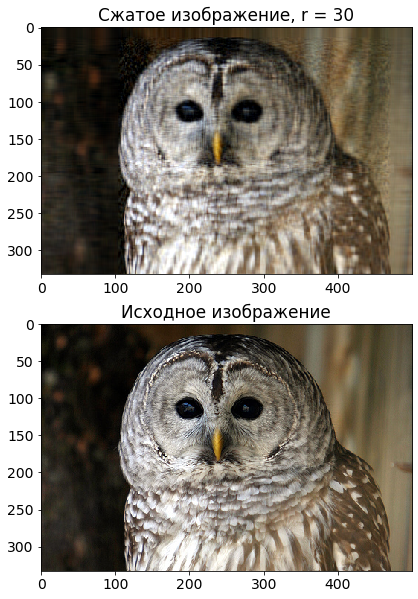

In [10]:
face_appr = np.zeros(shape = face.shape, dtype = float) 
r = 30# max(face.shape[0:1]) 
for i in range(0,3):
    u, s, v = np.linalg.svd(face[:,:,i])
    u_r = u[:, :r]
    s_r = s[:r]
    v_r = v[:r, :] 
    face_appr[:,:,i] = u_r.dot(np.diag(s_r).dot(v_r))
face_appr = np.clip(np.rint(face_appr), 0, 255)
face_appr = face_appr.astype('uint8')
error = face - face_appr

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,10))
ax2.imshow(face)
ax2.set_title('Исходное изображение')
ax1.set_title('Сжатое изображение, r = ' + str(r))
ax1.imshow(face_appr) 
print('average error = ', 
      (np.sum(error**2)/(face.shape[0] * face.shape[1] * 3))**(0.5)/255,
      '\nmax error = ', np.max(error))

## Применение SVD для латентно-семантического анализа текстов
Пример взят из курса https://github.com/oseledets/nla2019

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Создаём набор документов
docs = []
docs += ['Human machine interface for Lab ABC computer applications']
docs += ['A survey of user opinions of computer system response time']
docs += ['The EPS user interfaces management system']
docs += ['System and human system engineering testing of EPS']
docs += ['Relation of user-perceived response time on user management']
docs += ['The generation of random, binary, unordered trees']
docs += ['The intersection graph of paths in trees']
docs += ['Graph minors IV: Width of trees and well-quasi-ordering']
docs += ['Graph minors: A survey']
query = ['Human computer interaction']
docs +=  query # Запрос

vec = CountVectorizer()
X = vec.fit_transform(docs)
# Вычисляем матрицу document-term
X = X.toarray()

X = X.T
q = X[:, -1]
print(q)
X = X[:,0:-1]
print(X.shape)
df = pd.DataFrame(data = X, index=vec.get_feature_names())
df.head(10)

[0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
(41, 9)


,0,1,2,3,4,5,6,7,8
abc,1,0,0,0,0,0,0,0,0
and,0,0,0,1,0,0,0,1,0
applications,1,0,0,0,0,0,0,0,0
binary,0,0,0,0,0,1,0,0,0
computer,1,1,0,0,0,0,0,0,0
engineering,0,0,0,1,0,0,0,0,0
eps,0,0,1,1,0,0,0,0,0
for,1,0,0,0,0,0,0,0,0
generation,0,0,0,0,0,1,0,0,0
graph,0,0,0,0,0,0,1,1,1


Вычисляем близость запроса к документам для исходной матрицы, и после применения обрезанного SVD.

Вместо нулей появляются ненулевые значения, которые могут означать смысловую близость.

In [9]:
noncompress = q.dot(X)

u, s, v = np.linalg.svd(X)
r = 5
ur = u[:, :r]
sr = s[:r]
vr = v[:r, :] 
print(ur.shape)
Xr = ur @ np.diag(sr)

Xr  = ur.dot(np.diag(sr)).dot(vr)
compressed = q.dot(Xr)
res_all = np.vstack((noncompress, compressed)).T #To make two columns
print('There query is: {}, the scores are:'.format(query))
pd.DataFrame(res_all, index=docs[:-1], columns=['No SVD', 'SVD'])

(41, 5)
There query is: ['Human computer interaction'], the scores are:


,No SVD,SVD
Human machine interface for Lab ABC computer applications,2.0,2.044513
A survey of user opinions of computer system response time,1.0,0.887129
The EPS user interfaces management system,0.0,0.110677
System and human system engineering testing of EPS,1.0,0.989978
Relation of user-perceived response time on user management,0.0,0.059119
"The generation of random, binary, unordered trees",0.0,-0.000951
The intersection graph of paths in trees,0.0,-0.023512
Graph minors IV: Width of trees and well-quasi-ordering,0.0,0.046938
Graph minors: A survey,0.0,0.023327
